In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import astropy
import os
import pandas as pd
import xlsxwriter
import matplotlib as mpl

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools

# Load Files

In [2]:
good_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/cutout_23.3816_-6.8632.fits'

good_image_data = fits.getdata(good_image)

In [3]:
bad_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/cutout_23.7486_-6.3234.fits'

bad_image_data = fits.getdata(bad_image)

# Sigma Clipping

In [4]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

## Good Image

In [5]:
clipped_good_image_g = image_transform_sigma_clipping(good_image_data[0], sigma=3, central=True)
clipped_good_image_r = image_transform_sigma_clipping(good_image_data[1], sigma=3, central=True)
clipped_good_image_z = image_transform_sigma_clipping(good_image_data[2], sigma=3, central=True)

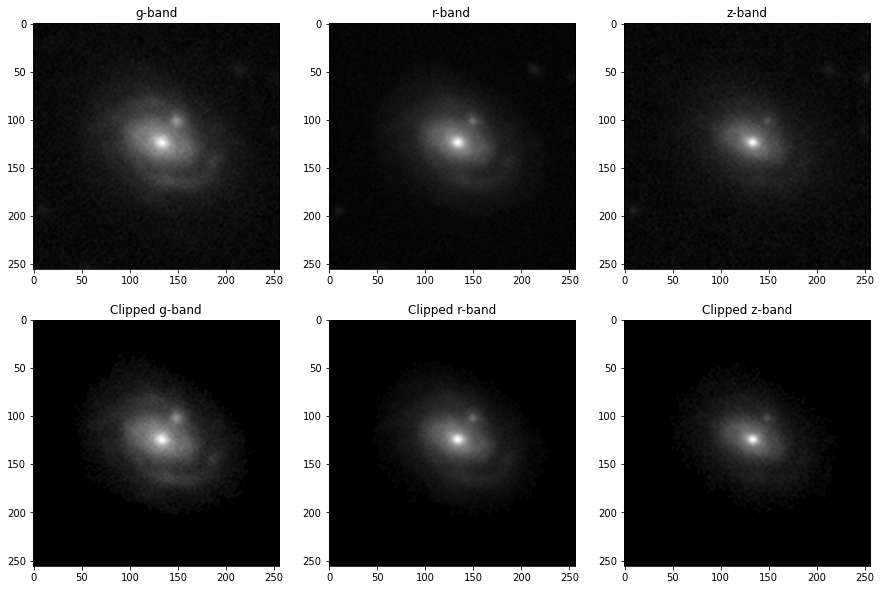

In [6]:
f = plt.figure(figsize = (15,20))

f.add_subplot(2,3, 1)
plt.imshow(good_image_data[0], cmap='gray')
plt.title('g-band')

f.add_subplot(1,3, 1)
plt.imshow(clipped_good_image_g, cmap='gray')
plt.title('Clipped g-band')


f.add_subplot(2,3, 2)
plt.imshow(good_image_data[1], cmap='gray')
plt.title('r-band')

f.add_subplot(1,3, 2)
plt.imshow(clipped_good_image_r, cmap='gray')
plt.title('Clipped r-band')


f.add_subplot(2,3, 3)
plt.imshow(good_image_data[2], cmap='gray')
plt.title('z-band')

f.add_subplot(1,3, 3)
plt.imshow(clipped_good_image_z, cmap='gray')
plt.title('Clipped z-band')

plt.show(block=True)

In [7]:
overlapped_good_image = np.add(good_image_data[0],good_image_data[1],good_image_data[2])

clipped_overlapped_good_image = image_transform_sigma_clipping(overlapped_good_image, sigma=3, central=True)

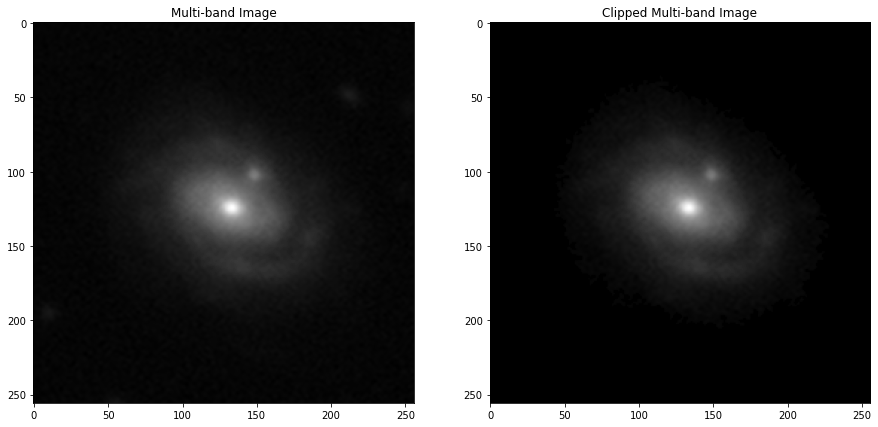

In [8]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2, 1)
plt.imshow(overlapped_good_image, cmap='gray')
plt.title('Multi-band Image')

f.add_subplot(1,2, 2)
plt.imshow(clipped_overlapped_good_image, cmap='gray')
plt.title('Clipped Multi-band Image')
plt.show()

## Bad Image

In [9]:
clipped_bad_image_g = image_transform_sigma_clipping(bad_image_data[0], sigma=3, central=True)
clipped_bad_image_r = image_transform_sigma_clipping(bad_image_data[1], sigma=3, central=True)
clipped_bad_image_z = image_transform_sigma_clipping(bad_image_data[2], sigma=3, central=True)

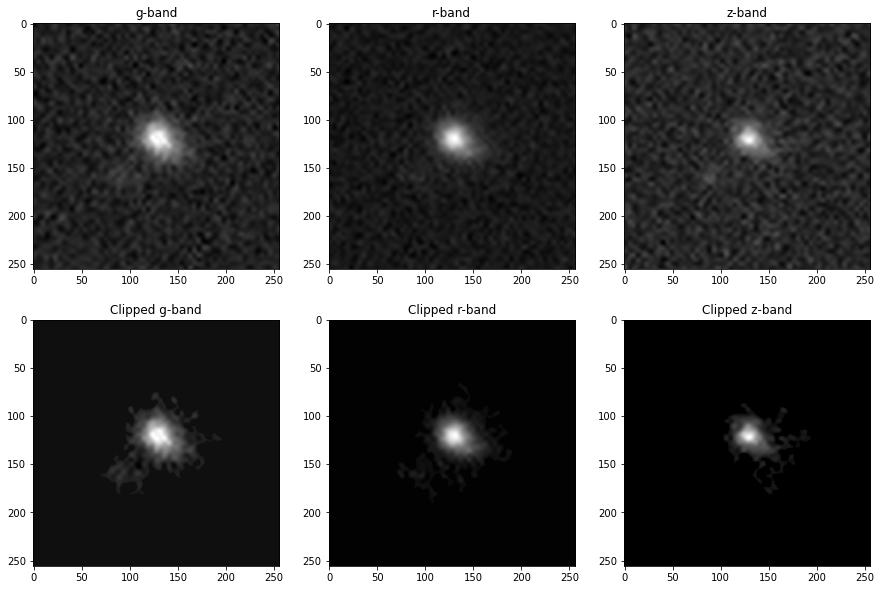

In [10]:
f = plt.figure(figsize = (15,20))

f.add_subplot(2,3, 1)
plt.imshow(bad_image_data[0], cmap='gray')
plt.title('g-band')

f.add_subplot(1,3, 1)
plt.imshow(clipped_bad_image_g, cmap='gray')
plt.title('Clipped g-band')


f.add_subplot(2,3, 2)
plt.imshow(bad_image_data[1], cmap='gray')
plt.title('r-band')

f.add_subplot(1,3, 2)
plt.imshow(clipped_bad_image_r, cmap='gray')
plt.title('Clipped r-band')


f.add_subplot(2,3, 3)
plt.imshow(bad_image_data[2], cmap='gray')
plt.title('z-band')

f.add_subplot(1,3, 3)
plt.imshow(clipped_bad_image_z, cmap='gray')
plt.title('Clipped z-band')

plt.show(block=True)

In [11]:
overlapped_bad_image = np.add(bad_image_data[0],bad_image_data[1],bad_image_data[2])

clipped_overlapped_bad_image = image_transform_sigma_clipping(overlapped_bad_image, sigma=3, central=True)

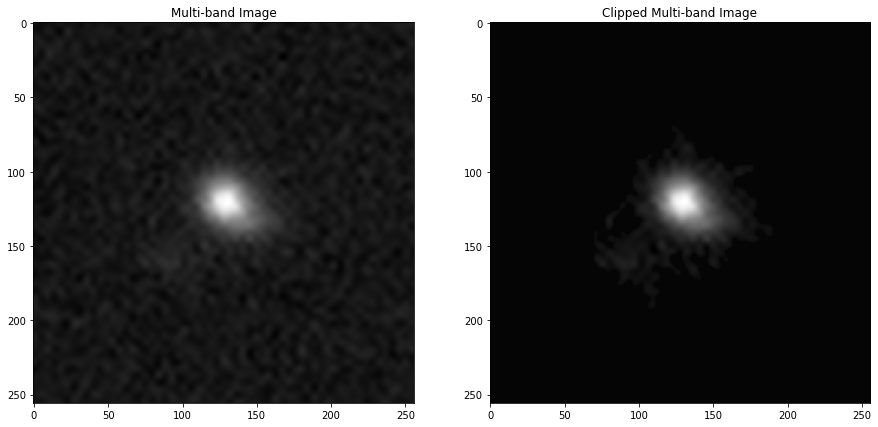

In [12]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2, 1)
plt.imshow(overlapped_bad_image, cmap='gray')
plt.title('Multi-band Image')

f.add_subplot(1,2, 2)
plt.imshow(clipped_overlapped_bad_image, cmap='gray')
plt.title('Clipped Multi-band Image')
plt.show()

# Contours

In [13]:
def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin, 
                            cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy

In [14]:
def draw_contour(contour, image, filled=False):
    """
    Draws a contour onto an image for diagnostic purposes

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    filled : bool, optional
        If true will fill in the contour otherwise will return an outline.
    Returns
    -------
    np.ndarray
        The image with the drawn contour on top
    """

    if filled:
        thickness = -1
        contour_arr = np.zeros([image.shape[0], image.shape[1]])
    else:
        thickness = 1
        contour_arr = image.copy()
    
    
    
    # This part determines which contour to draw. Also the difficult part since drawing all causes the ellipses
    # to fail. Will need to obtain the largest contour either HERE or before drawing the ellipse! 
    # (-1 is all contours)
    
    cv2.drawContours(contour_arr, contour, -1, (1, 1, 1), thickness)
    
    #cv2.drawContours(contour_arr, contour, 0, (1, 1, 1), thickness)
    
    print(np.shape(contour))
    
    return contour_arr

### Select Image

In [15]:
image = clipped_overlapped_bad_image

### Select Percentiles

In [16]:
percentiles=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

(1, 30, 1, 2)
(3,)


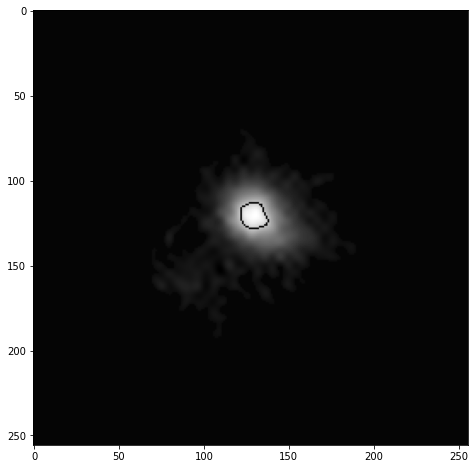

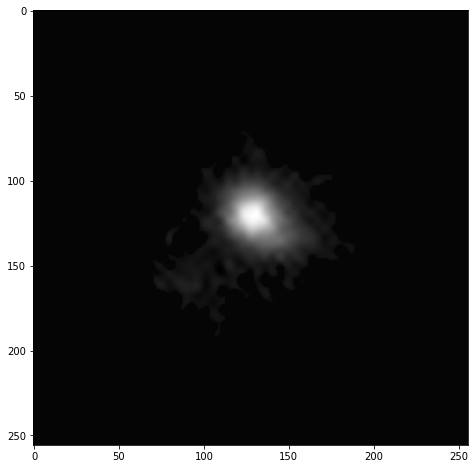

In [17]:
contours = []

for i in percentiles:
    
    contour_arr = image.copy()
    contour = find_contours(image, i)
    contours.append(contour[0])

    

d = 0
contours_all = []

for j in range(len(percentiles)):
    
    if len(contours[j]) != 0:
        
        ### Determine the contours
        contours_drawn = draw_contour(contours[j], image, filled=False)
        contours_all.append(contours_drawn)
        
        plt.figure(figsize = (8,8))
        plt.imshow(contours_drawn, cmap='gray')
    
    
    
    #Saving the files as a test
    
    #filename = '/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/Test jpg/Good Image z %d.jpg'%d
    #d+=1
    
    #plt.imsave(filename, contours_drawn, cmap='gray')

# Ellipse

In [18]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    try:
        ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour[0])
        ellipse_params = x0, y0, maj_axis, min_axis, theta

        if np.any(np.isnan(ellipse_params)):
            raised_error = True
            logging_tools.log('fit_ellipse failed with unknown error:')

    except cv2.error as e:
        logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
        raised_error = True

    if raised_error:
        if return_params:
            return ellipse_arr, default_return_params
        else:
            return ellipse_arr

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

### Function

In [55]:
def contours_and_ellipses (image, percentiles):
    #### Finding the contours ####

    contours = []

    for i in percentiles:
    
        contour_arr = image.copy()
        contour = find_contours(image, i)
        contours.append(contour[0])


    #### Drawing the contours and finding the ellipses ####    

    d = 0
    contours_all = []
    ellipse_parameters = []

    for j in range(len(percentiles)):
    
        if len(contours[j]) != 0:
        
            ### Determine the contours ###
            contours_drawn = draw_contour(contours[j], image, filled=False)
            contours_all.append(contours_drawn)
        
            ### Fit the Ellipses ###
            ellipse = fit_ellipse(contours[j], image, return_params=False)
            ellipse_param = fit_ellipse(contours[j], image, return_params=True)[1]
            ellipse_parameters.append(ellipse_param)
        
            ### Draw the Images ###
            f = plt.figure(figsize = (15,15))
            f.add_subplot(1,2, 1)
            plt.imshow(contours_drawn, cmap='gray')
            f.add_subplot(1,2, 2)
            plt.imshow(ellipse, cmap='gray')
            plt.show(block=True)
            
    return #ellipse_parameters

In [56]:
image = clipped_overlapped_good_image

percentiles = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

(1, 5, 1, 2)


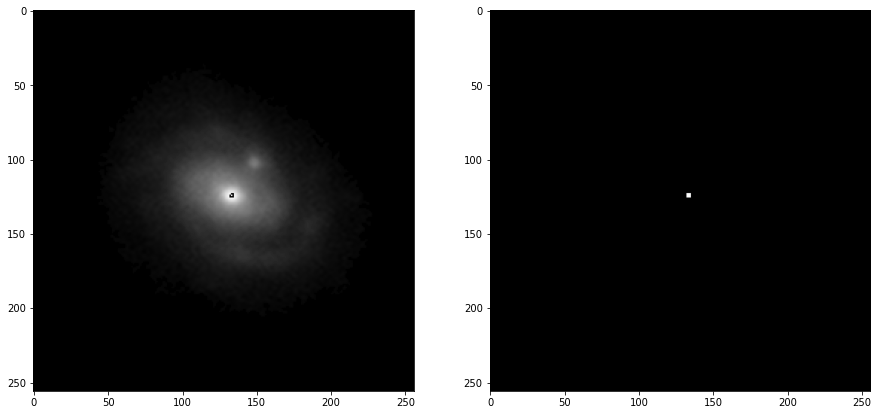

(1, 19, 1, 2)


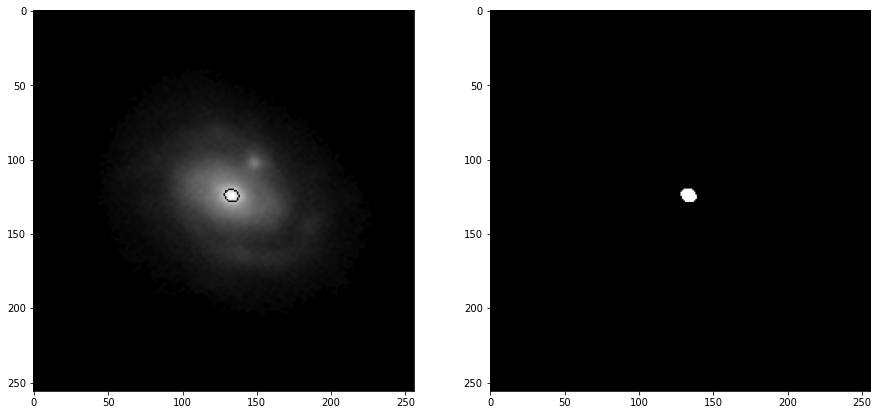

(1, 22, 1, 2)


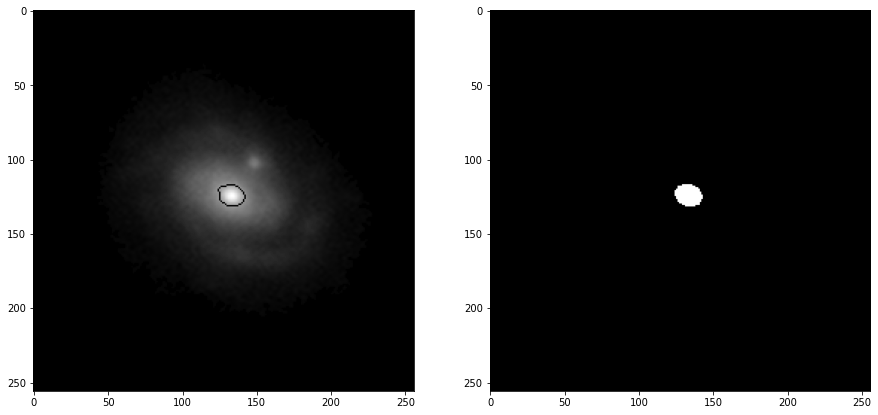

(2,)


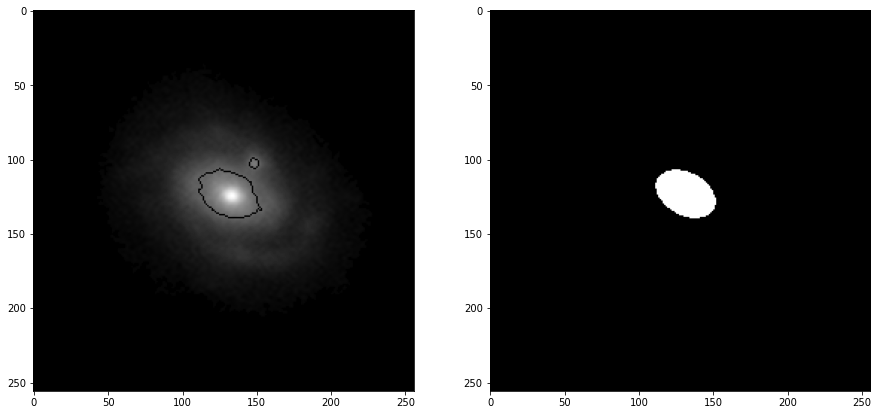

(6,)


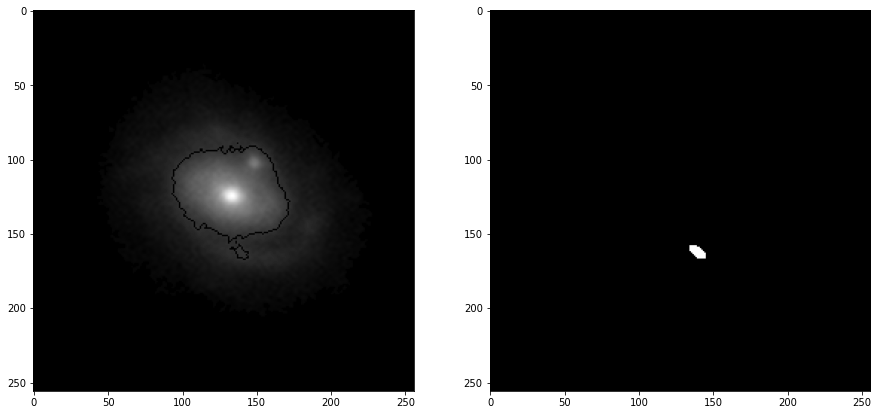

(1, 688, 1, 2)


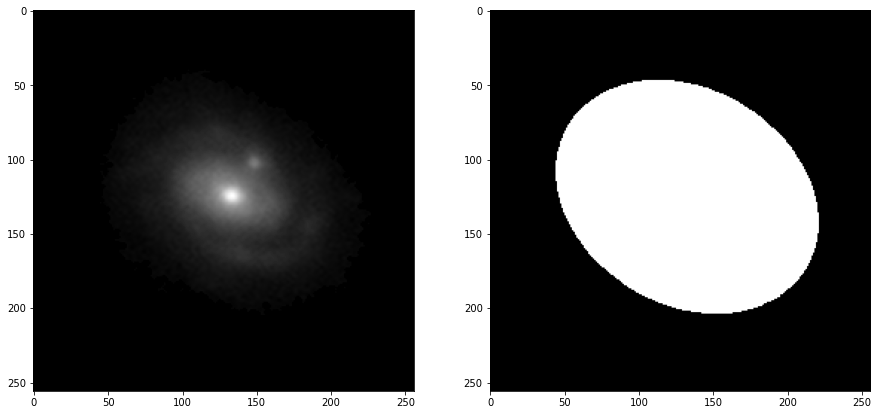

In [57]:
contours_and_ellipses(image, [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])

In [22]:
# Still testing...

c = max(contours[j], key = cv2.contourArea)